# Pump it Up: Data Mining the Water Table

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import widgets

In [2]:
import numpy as np 
import pandas as pd

In [3]:
X_train = pd.read_csv('data/Training-values.csv', parse_dates=['date_recorded'], index_col='id')
y_train = pd.read_csv('data/Training-labels.csv').set_index('id')

X_test = pd.read_csv('data/Test.csv', parse_dates=['date_recorded']).set_index('id')
submission = pd.read_csv('data/SubmissionFormat.csv').set_index('id')

In [4]:
X_train.head(3)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [5]:
X_train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 39 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null datetime64[ns]
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
recorded_by              59400 non-

In [7]:
X_train['payment'].unique()

array(['pay annually', 'never pay', 'pay per bucket', 'unknown',
       'pay when scheme fails', 'other', 'pay monthly'], dtype=object)

In [8]:
X_train['waterpoint_type'].unique()

array(['communal standpipe', 'communal standpipe multiple', 'hand pump',
       'other', 'improved spring', 'cattle trough', 'dam'], dtype=object)

###   The target labels

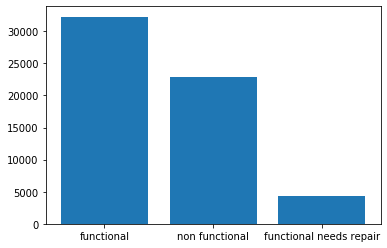

In [9]:
plt.bar(y_train['status_group'].unique(), y_train['status_group'].value_counts());

In [10]:
#  get into the right format for use in model training
y_train = y_train.values.reshape(-1)

###  Histograms of numeric values

In [11]:
numeric_values = sorted([c for c in X_train.columns if 
                   np.all(X_train[c].notna()) and 
                   X_train[c].dtype in ['float64', 'int64']])

In [12]:
def pump_plot(column):
    plt.hist(X_train[column], bins=20)
    plt.xticks(rotation=90)
    plt.xlabel(column)
    plt.ylabel('Number')
    
widgets.interact(pump_plot, column=numeric_values);

interactive(children=(Dropdown(description='column', options=('amount_tsh', 'construction_year', 'district_cod…

### Bar plots of categorical values

In [13]:
categorical_columns = [c for c in X_train.columns 
                       if X_train[c].dtype == 'object' and
                      np.all(X_train[c].notna()) 
                       and len(X_train[c].unique()) <= 10]

In [14]:
def bar_plot(column):
    plt.bar(X_train[column].unique(), X_train[column].value_counts())
    plt.xticks(rotation=90)
    
widgets.interact(bar_plot, column=categorical_columns);

interactive(children=(Dropdown(description='column', options=('basin', 'recorded_by', 'extraction_type_class',…

###  Predictions!! 

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto')

lr.fit(X_train[['amount_tsh']], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
lr.score(X_train[['amount_tsh']], y_train)

0.543080808080808

In [18]:
lr.predict(X_train[['amount_tsh']])[:5]

array(['functional', 'functional', 'functional', 'functional',
       'functional'], dtype=object)

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [20]:
X_train['region'].head()

id
69572     Iringa
8776        Mara
34310    Manyara
67743     Mtwara
19728     Kagera
Name: region, dtype: object

In [21]:
features = ColumnTransformer([
    ('numeric', StandardScaler(), 
         ['amount_tsh', 'latitude', 'longitude', 'gps_height']),
    ('categorical', OneHotEncoder(), 
         ['region', 'extraction_type', 'payment', 'payment_type'])
])

pipe = Pipeline([
    ('features', features),
    ('estimator', GridSearchCV(
        LogisticRegression(solver='lbfgs'),
        param_grid={'C': np.logspace(.001, 2, 10)}, cv=5, verbose=1))
])

In [22]:
pipe.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarni

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of itera

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of itera

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of itera

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of itera

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.5min finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lb

Pipeline(memory=None,
         steps=[('features',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['amount_tsh', 'latitude',
                                                   'longitude', 'gps_height']),
                                                 ('categorical',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=Non

In [23]:
pipe.score(X_train, y_train)   #  Accuracy on the training data! 

0.6523400673400673

In [24]:
pipe.named_steps['estimator'].best_params_

{'C': 1.0023052380778996}

In [25]:
pipe.predict(X_train)[:5]

array(['functional', 'non functional', 'functional', 'non functional',
       'functional'], dtype=object)

In [26]:
pd.Series(pipe.predict(X_train)).value_counts()

functional                 42369
non functional             17003
functional needs repair       28
dtype: int64

In [27]:
#  Real values

pd.Series(y_train).value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
dtype: int64